In [3]:
#!pip install openpyxl
#https://clio-infra.eu/Indicators/Height.html

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf

pd.options.mode.chained_assignment = None

df_ccode_iso = pd.read_csv('data/ccode_iso3.csv')
df_ccode_iso = df_ccode_iso[['name', 'country-code', 'alpha-3']]
df_ccode_iso.columns = ['name', 'ccode', 'iso_a3'].copy()


# load regions and equivalent country_name
df_regions_culture = pd.read_csv('data/ENS - Cultural Index - Countries Databases - consolidate_table.csv')
df_regions_culture = df_regions_culture[['region', 'iso_a3']].drop_duplicates()

# Load populatuion interpolated
df_iso = pd.read_csv('data/iso.csv', index_col = [0])
df_population_interpolated = pd.read_csv('data/population_interpolated.csv', index_col=[0])
df_population_interpolated = pd.merge(df_population_interpolated, df_iso, on = 'country_name')

df_population_region = pd.merge(df_population_interpolated, df_regions_culture, on ='iso_a3')
df_population_region['decade'] = df_population_region['year'].apply(lambda x: round(x / 10) * 10)
df_population_region = df_population_region.groupby(['region', 'decade'])['pop'].mean().reset_index()
df_population_region = df_population_region.rename(columns = {'region':'region_name'})

HomicideRates_Compact


/Users/charlesdedampierre/Desktop/cultura_project/.venv/lib/python3.11/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


Numeracy(Total)_Compact
Height_Compact


/Users/charlesdedampierre/Desktop/cultura_project/.venv/lib/python3.11/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/charlesdedampierre/Desktop/cultura_project/.venv/lib/python3.11/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/Users/charlesdedampierre/Desktop/cultura_project/.venv/lib/python3.11/site-packages/numpy/lib/function_base.py:2889: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/Users/charlesdedampierre/Desktop/cultura_project/.venv/lib/python3.11/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/Users/charlesdedampierre/Desktop/cultura_project/.venv/lib/python3.11/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/Use

GenderEqualityofNumeracy_Compact
LifeExpectancyatBirth(Total)_Compact


/Users/charlesdedampierre/Desktop/cultura_project/.venv/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/Users/charlesdedampierre/Desktop/cultura_project/.venv/lib/python3.11/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
/Users/charlesdedampierre/Desktop/cultura_project/.venv/lib/python3.11/site-packages/numpy/lib/function_base.py:2889: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/Users/charlesdedampierre/Desktop/cultura_project/.venv/lib/python3.11/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/Users/charlesdedampierre/Desktop/cultura_project/.venv/lib/python3.11/site-

UrbanizationRatio_Compact
CompositeMeasureofWellbeing_Compact
InfantMortality_Compact


/Users/charlesdedampierre/Desktop/cultura_project/.venv/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


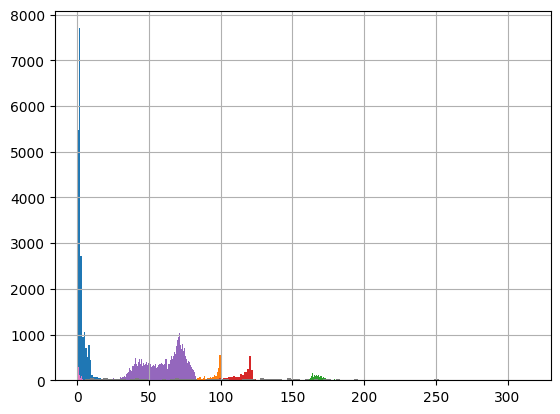

In [4]:
### Load CPI
path = '../3 - unseen_species_index/unseen_species_model/unseen_species_model_bayesian.csv'


df_cultura = pd.read_csv(path, index_col = [0])
df_cultura['N_est'] = df_cultura['f0'] + df_cultura['f1'] + df_cultura['f2'] # plus the individual
df_cultura = df_cultura.groupby(['region_name', 'decade']).agg({'N_est': 'sum', 'individual_wikidata_id':'count'}).reset_index()
df_cultura = df_cultura.rename(columns={"individual_wikidata_id": "score"})


hdi_variables = [{"original_name":'HomicideRates_Compact', "new_name":"homicide_rate"},
                {"original_name":'Numeracy(Total)_Compact', "new_name":"numeracy"},
                {"original_name":'Height_Compact', "new_name":"height"},
                {"original_name":'GenderEqualityofNumeracy_Compact', "new_name":"Gender_equality_num"},
                {"original_name":'LifeExpectancyatBirth(Total)_Compact', "new_name":"life_expectancy"},
                {"original_name":'UrbanizationRatio_Compact', "new_name":"urbanization"},
                {"original_name":'CompositeMeasureofWellbeing_Compact', "new_name":"wellbeing"},
                {"original_name":'InfantMortality_Compact', "new_name":"infant_mortality"}]


# Loop over the different dimensions of the Human Development

population = True
final_tables = []

for hdi_dict in hdi_variables:

    # hdi_dict = hdi_variables[1]

    original_name = hdi_dict['original_name']
    var =  hdi_dict['new_name']

    print(original_name)

    df_var = pd.read_excel(f'data/environment_data/{original_name}.xlsx', sheet_name='Data Long Format')
    df_var = df_var.rename(columns={'value':var, 'country.name':'name'})
    df_var = df_var.sort_values(var, ascending=False)
    df_var = df_var.drop('name', axis=1)


    df_var = pd.merge(df_var, df_ccode_iso, on = 'ccode')
    df_var = pd.merge(df_var, df_regions_culture, on = 'iso_a3')
    df_var = df_var.rename(columns={'name':'country_name'})


    # Make sure there are no negative values

    negative_values = ['CompositeMeasureofWellbeing_Compact', 'GenderEqualityofNumeracy_Compact']

    if original_name in negative_values:
        df_var[var]=df_var[var] + abs(min(df_var[var]))

    df_var[var].hist(bins=100)
    # plt.show()

    # Weight the values by population to properly represent regions that contain multiple aggregated countries.RetryClaude can make mistakes. Please double-check responses.
    var_weighted = f'{var}_weighted'
    df_var_pop = pd.merge(df_var, df_population_interpolated, on = ['year','iso_a3'])

    df_var_w = df_var_pop.groupby(['region', 'year']).apply(lambda x: (x[var] * x['pop']).sum() / x['pop'].sum())
    df_var_w = df_var_w.reset_index()
    df_var_w = df_var_w.rename(columns={0: var_weighted})


    df_var_w = df_var_w[df_var_w['year']<=1880]
    df_var_w['decade'] = df_var_w['year'].apply(lambda x: round(x / 10) * 10)

    # now, make the mean for every decade
    df_var_w = df_var_w.groupby(['region', 'decade'])[var_weighted].mean().reset_index()
    df_var_w = df_var_w.rename(columns={"region": "region_name"})


    #df_pop_w =  df_var_w.groupby(['region', 'decade'])['pop'].mean().reset_index()

    # df_var_w.to_csv('other_data/f{var}_weighted_pop_decade.csv')

    df = pd.merge(df_var_w, df_cultura, on = ['region_name', 'decade'])
    df = pd.merge(df, df_population_region, on = ['region_name', 'decade'])
    df = df.rename(columns = {'decade': 'year'})

    keep = ['Indian world',
    'Nordic countries',
    'Persian world',
    'Portugal',
    'United Kingdom',
    'France',
    'Greek World',
    'Arabic world',
    'Chinese world',
    'Japan',
    'German world',
    'Low countries',
    'Italy',
    'Korea',
    'Spain']

    # Apply normalization (Standard Deviation)

    df["century"] = df["year"].round(-2)
    df["score_log"] = np.log(df["score"])
    df["N_est_log"] = np.log(df["N_est"])
    df["score_log_std"] = df["score_log"] / df["score_log"].mean()
    df["N_est_std"] = df["N_est"] / df["N_est"].mean()
    df["N_est_log_std"] = df["N_est_log"] / df["N_est_log"].mean()
    df[f"log_{var}"] = np.log(df[f"{var}_weighted"])
    df[f"log_{var}_std"] = df[f"log_{var}"] / df[f"log_{var}"].mean()
    df[f"{var}_std"] = df[f"{var}_weighted"] / df[f"{var}_weighted"].mean()
    df["log_pop"] =  np.log(df["pop"])
    df["log_pop_std"] =  df["log_pop"] / df["log_pop"].mean()


    df = df[df['region_name'].isin(keep)]
    df_ols = df[['region_name', 'year', f'log_{var}_std', 'N_est_log_std', f"{var}_weighted", "log_pop_std"]].copy()


    # Fit Mixed Effects Model (with region as a random effect)

    # Add population as a cofoundinf factor
    if population is True:
        mixed_model = smf.mixedlm(f"log_{var}_std ~ N_est_log_std + log_pop_std", df_ols, groups=df_ols["region_name"])
    else:
        mixed_model = smf.mixedlm(f"log_{var}_std ~ N_est_log_std", df_ols, groups=df_ols["region_name"])
    result_mixed = mixed_model.fit()

    # Fit OLS Model (without fixed effects)
    ols_model = smf.ols(f"log_{var}_std ~ N_est_log_std", df_ols)
    result_ols = ols_model.fit()

    # Calculate the correlation coefficient for the OLS model (without fixed effects)
    correlation_ols = df_ols['N_est_log_std'].corr(df_ols[f"log_{var}_std"])

    # Calculate correlation coefficients for each group in the mixed effects model and take the average
    grouped = df_ols.groupby('region_name')
    correlation_mixed = grouped.apply(lambda g: g['N_est_log_std'].corr(g[f"log_{var}_std"])).mean()

    # Prepare the results dataframe
    results_df = pd.DataFrame({
        'Model': ['OLS Without FE', 'MixedLM With FE'],
        'Intercept': [f"{result_ols.params['Intercept']:.2f}", f"{result_mixed.params['Intercept']:.2f}"],
        'Intercept_SE': [f"{result_ols.bse['Intercept']:.2f}", f"{result_mixed.bse['Intercept']:.2f}"],
        'Intercept_CI': [f"({result_ols.conf_int().loc['Intercept'][0]:.2f}, {result_ols.conf_int().loc['Intercept'][1]:.2f})", 
                        f"({result_mixed.conf_int().loc['Intercept'][0]:.2f}, {result_mixed.conf_int().loc['Intercept'][1]:.2f})"],
        'Intercept_t-value': [f"{result_ols.tvalues['Intercept']:.2f}", f"{result_mixed.tvalues['Intercept']:.2f}"],
        'Coef': [f"{result_ols.params['N_est_log_std']:.2f}", f"{result_mixed.params['N_est_log_std']:.2f}"],
        'Coef_SE': [f"{result_ols.bse['N_est_log_std']:.2f}", f"{result_mixed.bse['N_est_log_std']:.2f}"],
        'Coef_CI': [f"({result_ols.conf_int().loc['N_est_log_std'][0]:.2f}, {result_ols.conf_int().loc['N_est_log_std'][1]:.2f})", 
                    f"({result_mixed.conf_int().loc['N_est_log_std'][0]:.2f}, {result_mixed.conf_int().loc['N_est_log_std'][1]:.2f})"],
        'Coef_t-value': [f"{result_ols.tvalues['N_est_log_std']:.2f}", f"{result_mixed.tvalues['N_est_log_std']:.2f}"],
        'Coef_p-value': [f"{result_ols.pvalues['N_est_log_std']:.3f}", f"{result_mixed.pvalues['N_est_log_std']:.3f}"],
        'Log-Likelihood': [f"{result_ols.llf:.2f}", f"{result_mixed.llf:.2f}"],
        'Correlation': [f"{correlation_ols:.2f}", f"{correlation_mixed:.2f}"],
        'N': [f"{result_ols.nobs:.0f}", f"{result_mixed.nobs:.0f}"],
        'R-squared': [f"{result_ols.rsquared:.2f}", "N/A"]
    })

    # Transpose the DataFrame for the desired format and add variable name
    results_df = results_df.T
    results_df.columns = results_df.iloc[0]  # Set the first row as column headers
    results_df = results_df[1:]  # Remove the first row as it's now redundant
    results_df['Variable'] = var

    # Save the results to a CSV file
    #results_df.to_csv(f'df_indicators_hdi/regression_table_{var}.csv')

    final_tables.append(results_df)

# Consolidate the table
data = pd.concat([x for x in final_tables])
data = data.reset_index()
data = data.rename(columns = {'index':'measure'})
list(set(data['measure']))

data = data.sort_values(['Variable', 'measure'])

if population is False:
    data.to_csv('data/hdi_table.csv')
else:
     data.to_csv('data/hdi_table_population.csv')
